In [8]:
import requests
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from config import 

g_url = 'https://maps.googleapis.com/maps/api/geocode/json?&address='
fifa_url = 'https://worldcup.sfg.io/teams/results'


In [28]:
country1 ='denver'
country2 = 'san diego'
response = requests.get(dir_url + country1 + '&destinations='+ country2 + '&apikey=' + g_key).json()
response

{'destination_addresses': ['San Diego, CA, USA'],
 'origin_addresses': ['Denver, CO, USA'],
 'rows': [{'elements': [{'distance': {'text': '1,078 mi', 'value': 1734714},
     'duration': {'text': '15 hours 43 mins', 'value': 56580},
     'status': 'OK'}]}],
 'status': 'OK'}

In [59]:
#request data on all the teams in the 2018 World cup
response = requests.get(fifa_url).json()
teams_df = pd.DataFrame(response)
teams_df.index = teams_df['country']
del teams_df['alternate_name']
teams_df.head()


,country,draws,fifa_code,games_played,goal_differential,goals_against,goals_for,group_id,group_letter,id,losses,points,wins
country,,,,,,,,,,,,,
Korea Republic,Korea Republic,0,KOR,3,0,3,3,6,F,24,2,3,1
Germany,Germany,0,GER,3,-2,4,2,6,F,21,2,3,1
Serbia,Serbia,0,SRB,3,-2,4,2,5,E,20,2,3,1
Costa Rica,Costa Rica,1,CRC,3,-3,5,2,5,E,19,2,1,0
Belgium,Belgium,0,BEL,7,10,6,16,7,G,25,1,18,6


In [82]:
matches_url = 'https://worldcup.sfg.io/matches'
match_df = pd.DataFrame(requests.get(matches_url).json())
match_df
first_stage = match_df[match_df['stage_name']=='First stage']
round_sixteen = match_df[match_df['stage_name']=='Round of 16']
quartfinals = match_df[match_df['stage_name']=='Quarter-finals']
semifinals = match_df[match_df['stage_name']=='Semi-finals']
final = match_df[match_df['stage_name']=='Final']


In [103]:
#goal_times = {}
goal_times_dict = {
    'First stage':{},
    'Round of 16':{},
    'Quarter-finals': {},
    'Semi-finals': {},
    'Play-off for third place':{},
    'Final':{} 
}

goal_times_means = pd.DataFrame()

for index, match in match_df.iterrows():
    
    home = match['home_team_country']
    away = match['away_team_country']
    home_event = match['home_team_events']
    away_event = match['away_team_events']
    team_events = [home_event, away_event]
    teams = [home, away]
    goal_times = goal_times_dict[match['stage_name']]
    
    for events in team_events:
        team = teams[team_events.index(events)]
        for event in events: 
            if (event['type_of_event'] == 'goal'):
                time = event['time']
                time = time.replace("'", "")
                
                try:
                    time = int(time)
                except:
                    time = eval(time)
                    
                if team in goal_times:
                    goal_times[team].append(time)
                else:
                    goal_times[team] = []
                    goal_times[team].append(time)
                    goal_type[team] = 0
            else:
                continue

for stage in goal_times_dict:
    for country in goal_times_dict[stage]:
        goal_times_means.loc[country, stage] = np.mean(goal_times_dict[stage][country])


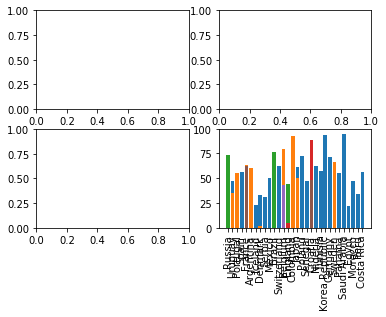

In [141]:
plt.subplots(2,2)

for stage in goal_times_means:
    
    plt.bar(np.arange(0, len(goal_times_means[stage])), goal_times_means[stage])
    countrys = goal_times_means.index.tolist()
    plt.xticks(np.arange(0, len(goal_times_means[stage])), countrys, rotation=90)

In [66]:
goal_type

{'Russia': 0,
 'Uruguay': 0,
 'Portugal': 0,
 'Spain': 0,
 'France': 0,
 'Argentina': 0,
 'Iceland': 0,
 'Denmark': 0,
 'Serbia': 0,
 'Mexico': 0,
 'Brazil': 0,
 'Switzerland': 0,
 'Belgium': 0,
 'England': 0,
 'Colombia': 0,
 'Japan': 0,
 'Poland': 0,
 'Senegal': 0,
 'Croatia': 0,
 'Nigeria': 0,
 'Tunisia': 0,
 'Korea Republic': 0,
 'Germany': 0,
 'Sweden': 0,
 'Panama': 0,
 'Saudi Arabia': 0,
 'Egypt': 0,
 'Morocco': 0,
 'Peru': 0,
 'Costa Rica': 0}

In [282]:
winning_fouls_total = 0
losing_fouls_total = 0
foul_avg = {}
for i in np.arange(0,len(match_df)-1):
    
    #grab country names and fouls committed
    winner = match_df.iloc[i,20]
    row = match_df.iloc[i,:]
    home = row['home_team_country']
    away = row['away_team_country']
    home_foul = row['home_team_statistics']['fouls_committed']
    away_foul = row['away_team_statistics']['fouls_committed']
    
    #fix data for none values
    if (home_foul == None):
        home_foul=0
    if (away_foul == None):
        away_foul = 0
        
    #add both foul counts to country totals
    if (home in foul_avg):
        foul_avg[home] += home_foul
    else:
        foul_avg[home] = home_foul
    if (away in foul_avg):
        foul_avg[away] += away_foul
    else:
        foul_avg[away] = away_foul
        
    #add foul counts to winning and losing foul counts
    if (row['home_team_country'] == winner) :
        winning_fouls_total += home_foul
        losing_fouls_total += away_foul
    elif (row['away_team_country'] == winner) :
        winning_fouls_total += away_foul
        losing_fouls_total += home_foul
    else:
        continue
            
    #if theres a draw, dont add to winner count but still add to the country totals      
 

In [283]:
print(foul_avg)

games_won = []
#calculate average fouls based on foul dictionary
for country in teams_df['country']:
    games = teams_df.loc[country, 'games_played']
    foul_avg[country] = foul_avg[country]/games
    won = teams_df.loc[country, 'points']
    games_won.append(won)


{'Russia': 95, 'Saudi Arabia': 30, 'Egypt': 38, 'Uruguay': 61, 'Morocco': 62, 'Iran': 44, 'Portugal': 55, 'Spain': 34, 'France': 78, 'Australia': 37, 'Argentina': 55, 'Iceland': 34, 'Peru': 37, 'Denmark': 54, 'Croatia': 100, 'Nigeria': 46, 'Costa Rica': 43, 'Serbia': 45, 'Germany': 29, 'Mexico': 54, 'Brazil': 50, 'Switzerland': 52, 'Sweden': 64, 'Korea Republic': 62, 'Belgium': 97, 'Panama': 35, 'Tunisia': 46, 'England': 58, 'Colombia': 53, 'Japan': 29, 'Poland': 16, 'Senegal': 30}


([<matplotlib.axis.XTick at 0x1b2909aaf60>,
 <a list of 32 Text xticklabel objects>)

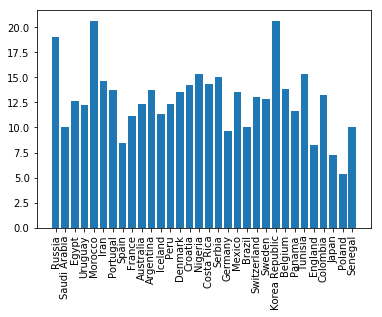

In [284]:
plt.bar(range(len(foul_avg)), list(foul_avg.values()), align='center')
plt.xticks(range(len(foul_avg)), list(foul_avg.keys()), rotation = 90)

#country's foul average per game


<BarContainer object of 2 artists>

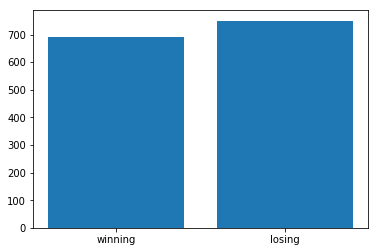

In [285]:
plt.bar(['winning', 'losing'],[winning_fouls_total, losing_fouls_total])
#total fouls

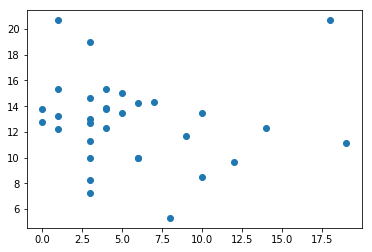

In [286]:
#games won vs avg fouls
plt.scatter(games_won, list(foul_avg.values()))

,a,b,c,d,e,f,g,h
matches,"[{'name': 1, 'type': 'group', 'home_team': 1, ...","[{'name': 3, 'type': 'group', 'home_team': 5, ...","[{'name': 5, 'type': 'group', 'home_team': 9, ...","[{'name': 7, 'type': 'group', 'home_team': 13,...","[{'name': 9, 'type': 'group', 'home_team': 17,...","[{'name': 11, 'type': 'group', 'home_team': 21...","[{'name': 13, 'type': 'group', 'home_team': 25...","[{'name': 15, 'type': 'group', 'home_team': 29..."
name,Group A,Group B,Group C,Group D,Group E,Group F,Group G,Group H
runnerup,1,5,12,13,18,22,28,32
winner,4,6,9,15,17,23,25,31


,matches
a,"[{'name': 1, 'type': 'group', 'home_team': 1, ..."
b,"[{'name': 3, 'type': 'group', 'home_team': 5, ..."
c,"[{'name': 5, 'type': 'group', 'home_team': 9, ..."
d,"[{'name': 7, 'type': 'group', 'home_team': 13,..."
e,"[{'name': 9, 'type': 'group', 'home_team': 17,..."
f,"[{'name': 11, 'type': 'group', 'home_team': 21..."
g,"[{'name': 13, 'type': 'group', 'home_team': 25..."
h,"[{'name': 15, 'type': 'group', 'home_team': 29..."


matches    [{'name': 1, 'type': 'group', 'home_team': 1, ...
Name: a, dtype: object